In [226]:
# import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import datetime 
import warnings
warnings.simplefilter("ignore")
import tsfel
import biosppy



In [227]:
### Data load and Pre-Processing ### 

def get_data(input_path):
    """
    

    Args:
        input_path (_type_): _description_

    Returns:
        _type_: _description_
        
    """
    file_list = ['ACC.csv', 'BVP.csv', 'EDA.csv','HR.csv','IBI.csv','TEMP.csv']
    df_list = []

    for idx in range(len(file_list)):
        temp_path = input_path + file_list[idx]
        df = pd.read_csv(temp_path)
        df = df.iloc[1:]
        df_list.append(df)
        
    return df_list


### Time-Series Segmentation function ###

def ts_segment(array, n_segment, type_segment):
    
    """_summary_
        
    # make segmentations from a time-series dataset

    Input arguments:
    
    # array : 
    # n_segment : 
    # type_segment : 
    
    Returns:
        _type_: _description_
    """
    
    segment_count = 0
    segment_list = []
    
    
    for num_seg in range(n_segment):
        
        if num_seg == 0:
            
            if type_segment == "HR" :
                
                n_rows = 4
                temp_segment = array.loc[:n_rows]
                temp_segment.columns = ['ts']
                segment_list.append(temp_segment)
                
            elif type_segment == "EDA":
            
                temp_rows = 160
                temp_segment = array.loc[:temp_rows]
                temp_segment.columns = ['ts']
                segment_list.append(temp_segment) 
            
        else:
            
            if type_segment == "HR" :
                
                n_rows = 3
                start_row = num_seg * n_rows
                start_index = start_row
                end_index = (num_seg + 1)*n_rows
                temp_segment = array.loc[start_index : end_index]
                temp_segment.columns = ['ts']
                segment_list.append(temp_segment)
                
            elif type_segment == "EDA":
            
                temp_rows = 120
                start_row = num_seg * temp_rows
                start_index = start_row - 40
                end_index = start_row + temp_rows
                temp_segment = array.loc[start_index : end_index - 1]
                temp_segment.columns = ['ts']
                segment_list.append(temp_segment) 
            
            
    return segment_list 
    

### Exploratory Data Analysis & Visualization ###

def eda_analyze(input_data, vis = False):
    
    temp_desc = input_data.describe()
    
    if vis == True:
        
        fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(6,10))         
        
        ax[0].hist(input_data['ts'], edgecolor = "black", color = "b")
        ax[1].boxplot(input_data.ts)
        plt.show()
    else:
        pass
                
    return temp_desc


## Features Extraction with TSFEL Library ## 
# https://www.aicos.fraunhofer.pt/content/dam/portugal/aicos/scientific-expertise/competence-articles/IS_TSFEL-%20Time%20Series%20Feature%20Extraction%20Library.pdf

def generate_features(input_data, feat_type, selection = False):
    
    """_summary_

    Args:
        input_data (_type_): _description_
        feat_type (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    cfg_type = tsfel.get_features_by_domain(feat_type)
    data_analyze = tsfel.time_series_features_extractor(cfg_type, input_data)
    
    if selection == True:
        
        corr_features = tsfel.correlated_features(data_analyze)
        data_analyze.drop(corr_features, axis=1, inplace=True)
    
    else: 
        pass
    
    return data_analyze




## Electrodermal Activity(EDA) Noise Reducition and Decomposition ## 

## The main purpose of using this python library (pyEDA) is noise reduction of raw electrodermal activity data
## However, the library provides several useful functions for features extraction/
from pyEDA.main import *

def eda_signal_process(eda_signal_list):
     
    """_summary_

    Args:
        eda_signal_list (_type_): _description_
    """
    
    phasic_gsr_list = []
    tonic_gsr_list = []

    for idx in range(len(eda_signal_list)):
        temp_segment = eda_signal_list[idx]
        m, wd, eda_clean = process_statistical(temp_segment, use_scipy=True, sample_rate=4, new_sample_rate=4, segment_width=160, segment_overlap=0)

        temp_phasic = wd['filtered_phasic_gsr'][0]
        temp_tonic  = wd['tonic_gsr'][0]
        phasic_gsr_list.append(temp_phasic)
        tonic_gsr_list.append(temp_tonic)

    return phasic_gsr_list , tonic_gsr_list



## Feature Engineering with Heart Rate Data ##

def hr_features(input_data):
    
    # Implemented from 
    # https://www.kaggle.com/code/bjoernjostein/heart-rate-variability-hrv-analysis/notebook#Heart-Rate-Variability-(HRV)-analysis-using-time-domain,-frequency-domain-and-non-linear-methods
    
    outcomes = {}
    
    outcomes['Mean HR'] = np.mean(input_data)
    outcomes['STD HR'] = np.std(input_data)
    outcomes['Min HR'] = np.min(input_data)
    outcomes['Max HR'] = np.max(input_data)
    
    return outcomes

In [228]:
file_path = '1642681750_A034B3_num_001-20220917T180233Z-001/1642681750_A034B3_num_001/'
data_list = get_data(file_path)

In [229]:
eda_data = data_list[2]
eda_data.columns = ['ts']
eda_segment = ts_segment(eda_data, 114, 'EDA')

In [230]:
eda_segment = ts_segment(eda_data, 114, 'EDA')
temp_eda_segment = eda_segment[12]

In [231]:
phasic_list, tonic_list = eda_signal_process(eda_segment)

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2430e+00 -6.9870e+00  2e+02  1e+01  3e+00
 1: -7.0704e+00 -1.8888e+01  1e+01  9e-01  2e-01
 2: -7.3439e+00 -1.0276e+01  3e+00  2e-01  4e-02
 3: -7.4506e+00 -8.1015e+00  7e-01  3e-02  7e-03
 4: -7.5192e+00 -7.6494e+00  1e-01  3e-03  8e-04
 5: -7.5729e+00 -7.5906e+00  2e-02  9e-05  2e-05
 6: -7.5815e+00 -7.5857e+00  4e-03  2e-05  5e-06
 7: -7.5836e+00 -7.5841e+00  6e-04  1e-06  3e-07
 8: -7.5837e+00 -7.5839e+00  1e-04  8e-08  2e-08
 9: -7.5838e+00 -7.5838e+00  3e-05  1e-08  3e-09
10: -7.5838e+00 -7.5838e+00  5e-06  2e-09  4e-10
11: -7.5838e+00 -7.5838e+00  9e-07  3e-10  6e-11
12: -7.5838e+00 -7.5838e+00  2e-07  3e-11  7e-12
13: -7.5838e+00 -7.5838e+00  1e-08  2e-12  5e-13
Optimal solution found.
If you are using this tool for your research please cite this pape

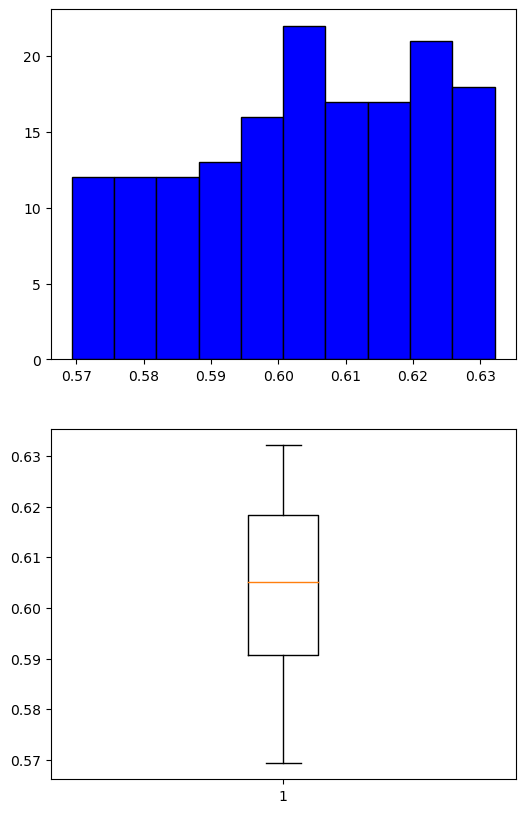

In [232]:
data_info = eda_analyze(temp_eda_segment, vis=True)

In [233]:
feature_list = ['statistical', 'temporal', 'spectral']
features_outcomes = []

for feat_type in feature_list:
    
    temp_features = generate_features(temp_eda_segment,feat_type)
    features_outcomes.append(temp_features)


*** Feature extraction started ***
16



*** Feature extraction finished ***
*** Feature extraction started ***
18



*** Feature extraction finished ***
*** Feature extraction started ***
26



*** Feature extraction finished ***


In [234]:
## Heart_Rate Data ##

hr_segment = ts_segment(hr_data,114, 'HR')

In [235]:
temp_hr_data = hr_segment[5]

In [236]:
hr_stats = hr_features(temp_hr_data)

In [237]:
print(hr_stats['Mean HR'])
print(hr_stats['STD HR'])
print(hr_stats['Min HR'])
print(hr_stats['Max HR'])

ts    98.94
dtype: float64
ts    0.907056
dtype: float64
ts    97.78
dtype: float64
ts    100.2
dtype: float64
